In [1]:
# Importing all the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import datetime, argparse
import pandas as pd
from mri.operators import Stacked3DNFFT, NonCartesianFFT, WaveletN, WaveletUD2
from mri.operators.utils import normalize_frequency_locations
from mri.reconstructors import SelfCalibrationReconstructor, SingleChannelReconstructor, CalibrationlessReconstructor
from mri.operators.fourier.utils import estimate_density_compensation
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold, GroupLASSO
from mri.operators import ORCFFTWrapper
from sparkling.utils.gradient import get_kspace_loc_from_gradfile, get_kspace_points_grads_n_slew
from sparkling.utils.plotting import scatter_shots
from sparkling.utils.shots import convert_NCxNSxD_to_NCNSxD, convert_NCNSxD_to_NCxNSxD
from sparkling.utils.argparse import get_params_n_basename

/neurospin/optimed/KPooja/Environments/EPI_sparkling/lib/python3.8/site-packages/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "


In [2]:
# Loading the data & trajectory
kspacedata = pd.read_csv('120623_2DSPARK_64shots_50acq_test2_phantom_vo0.dat', sep="\s+", header=None)
traj_file = "/neurospin/optimed/KPooja/Sparkling/Output/dim2_i_RadialIO_TRW0.0_N256x256_FOV0.2x0.2_Nc64_Ns720_OSF1_c25.0_d1.1__D12M6Y2023T1522.bin"

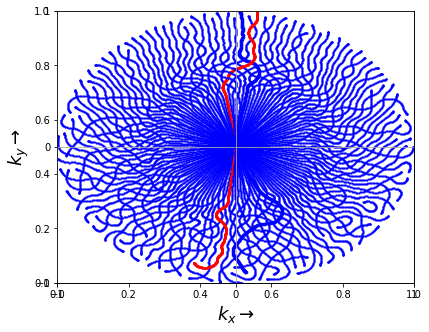

/neurospin/optimed/KPooja/Sparkling/CSMRI_sparkling/sparkling/utils/gradient.py:28: UserWarning: Gradient Maximum Maginitude overflow from Machine capabilities
  warnings.warn("Gradient Maximum Maginitude "
/neurospin/optimed/KPooja/Sparkling/CSMRI_sparkling/sparkling/utils/gradient.py:33: UserWarning: Slew Rate overflow from Machine capabilities!
Occurences per shot : 11.265625
Max Value : 0.0002836107374525682
  warnings.warn("Slew Rate overflow from Machine capabilities!\n"


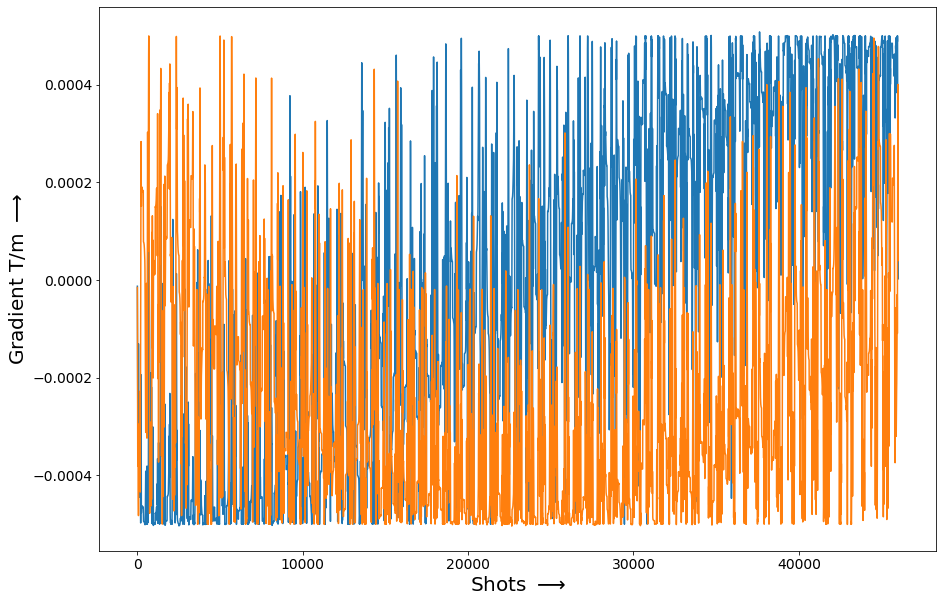

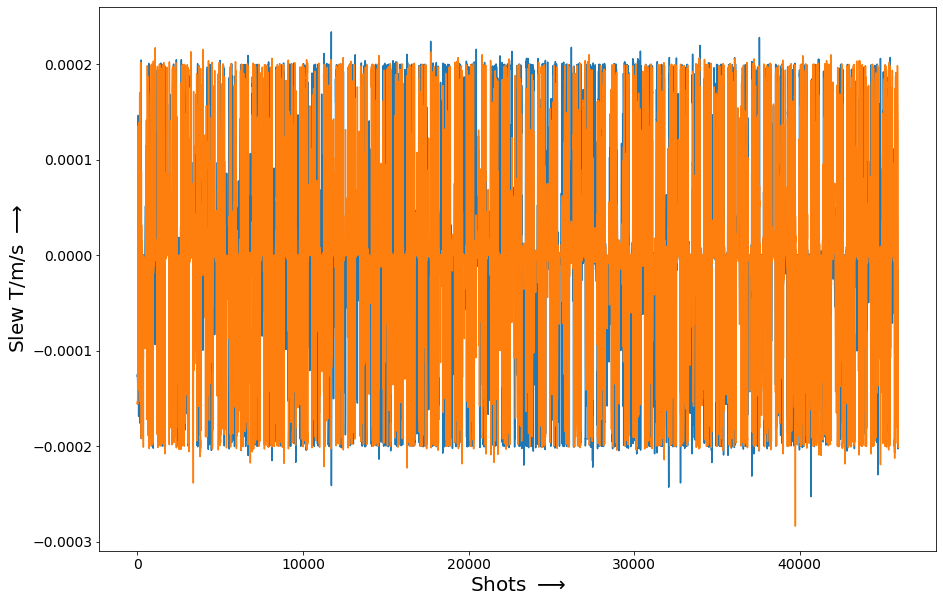

In [3]:
shots, params = get_kspace_loc_from_gradfile(traj_file, verbose=1)
INIT, filename = get_params_n_basename(traj_file)
grads, k0, slew = get_kspace_points_grads_n_slew(
    shots,
    INIT,
    check=True,
    normalized=False
)

plt.figure(figsize=(15,10))
plt.plot(convert_NCxNSxD_to_NCNSxD(grads))
plt.xlabel('Shots $\longrightarrow$', fontsize = 20)
plt.ylabel('Gradient T/m $\longrightarrow$', fontsize = 20)
plt.tick_params(labelsize=14)

plt.figure(figsize=(15,10))
# plt.plot(slew[25,:,1], label="S$_x$")
# plt.plot(slew[25,:,0], label="S$_y$")
plt.plot(convert_NCxNSxD_to_NCNSxD(slew))
plt.xlabel('Shots $\longrightarrow$', fontsize = 20)
plt.ylabel('Slew T/m/s $\longrightarrow$', fontsize = 20)
plt.tick_params(labelsize=14)
# plt.legend(loc="upper right", prop={'size': 16})
# plt.legend(loc="upper right", fontsize = 20)


In [5]:
# Defining fuctions to get trajectory parameters and sample location
def get_traj_params(traj_file):
    dico_params = get_kspace_loc_from_gradfile(traj_file)[1]
    FOV = dico_params['FOV']
    M = dico_params['img_size']
    Ns = dico_params['num_samples_per_shot']
    OS = dico_params['min_osf']
    Nc = dico_params['num_shots']
    return(FOV, M, Ns, OS, Nc)

def get_norm_samples(filename, dwell_t, num_adc_samples, kmax):
    sample_locations = convert_NCxNSxD_to_NCNSxD(get_kspace_loc_from_gradfile(filename, dwell_t, num_adc_samples)[0])
    sample_locations = normalize_frequency_locations(sample_locations, Kmax= kmax)
    return sample_locations

def single_coil_recon(mu, dens_compense, kspace_data, kspace_loc, M, iter):
    if dens_compense == True:
        density_comp = estimate_density_compensation(kspace_loc, M)                              
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              density_comp = density_comp,
                              n_coils=1,)
    else:
        fourier_op = NonCartesianFFT(samples=kspace_loc,
                              shape= M,
                              implementation='gpuNUFFT',
                              n_coils=1,)
    
    regularizer_op = SparseThreshold(Identity(), mu, thresh_type="soft")
    
    linear_op = WaveletN(wavelet_name='sym8',
                         nb_scale=3,
                         dim=2,
                         padding='periodization')
        
    reconstructor = SingleChannelReconstructor(
                        fourier_op=fourier_op,
                        linear_op=linear_op,
                        regularizer_op=regularizer_op,
                        gradient_formulation='synthesis',
                        verbose=21,
                        )

    reconst_data, costs, metrics = reconstructor.reconstruct(kspace_data= kspace_data, optimization_alg = 'pogm', num_iterations = iter,)

    return(reconst_data, costs, metrics)

In [6]:
FOV, M, Ns, OS, Nc = get_traj_params(traj_file)
dwell_time = 0.1e-3 / OS
nb_adc_samples = Ns*OS
Te = 31e-3
time_vec = dwell_time * np.arange(nb_adc_samples)
echo_time = Te - dwell_time * nb_adc_samples / 2
time_vec = (time_vec + echo_time)

In [7]:
Kspace_real = kspacedata.iloc[:, 3]
Kspace_imag = kspacedata.iloc[:, 4]
K_real = np.array(Kspace_real)
K_imag = np.array(Kspace_imag)

kspace_data = np.zeros((Nc * Ns),dtype = np.complex_)
kspace_data.real = K_real
kspace_data.imag = K_imag

In [9]:
FOV, M, Ns, OS, Nc = get_traj_params(traj_file)
kspace_loc = get_norm_samples(traj_file, dwell_t = dwell_time*1e3, num_adc_samples = Ns*OS, kmax=(M[0]/(FOV[0]), M[1]/FOV[1]))

density_comp = estimate_density_compensation(kspace_loc, M)
fourier_op = NonCartesianFFT(
        samples=kspace_loc,
        shape=M,
        implementation='gpuNUFFT',
        density_comp = density_comp,
        n_coils= 1)

new_kspace = np.ascontiguousarray(kspace_data)       

print(kspace_loc.shape)
kspace_locations = kspace_loc.reshape((-1, 2)).astype(np.float32)
print(kspace_locations.shape)

(46080, 2)
(46080, 2)


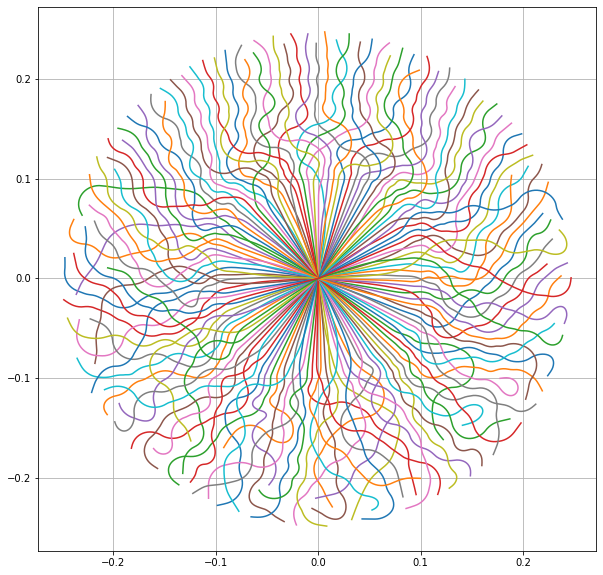

In [10]:
nb_shots = 64
plt.figure(num=3, figsize = (10,10))
for i in range(nb_shots):
    plt.plot(kspace_locations.reshape((-1, Ns*OS, 2))[i, :, 0],
             kspace_locations.reshape((-1, Ns*OS, 2))[i, :, 1])
plt.grid()
plt.show()


In [11]:
recont_data, costs, metric= single_coil_recon(1e-2, True, new_kspace, kspace_loc, (128,128), 200)

Lipschitz constant is 0.20580545216798785
The lipschitz constraint is satisfied
 - mu:  0.01
 - lipschitz constant:  0.20580545216798785
 - data:  (128, 128)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f5b3024ec10> - 3
 - max iterations:  200
 - image variable shape:  (1, 128, 128)
----------------------------------------
Starting optimization...


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  1% (3 of 200) |                        | Elapsed Time: 0:00:00 ETA:  00:00:00
  3% (6 of 200) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04
  5% (11 of 200) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:03
  8% (16 of 200) |#                      | Elapsed Time: 0:00:00 ETA:   0:00:03
 10% (21 of 200) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 13% (26 of 200) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:03
 15% (31 of 200) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:03
 18% (36 of 200) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 20% (41 of 200) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:03
 22% (44 of 200) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:03
 24% (49 of 200) |#####                  | Elapsed Time: 0:00:01 ETA:   0:00:03
 27% (54 of 200) |######                

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  4.371584691107273  seconds
----------------------------------------


(128, 128)


Text(0.5, 1.0, '2D VLFMRI Prospective Sparkling')

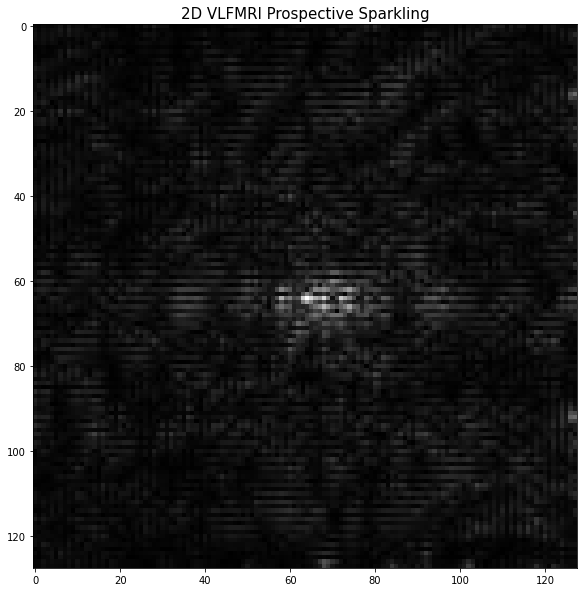

In [13]:
import matplotlib.pyplot as plt
from modopt.math.metrics import ssim, psnr
plt.figure(figsize = (10,10))
vol = recont_data
print(vol.shape)
plt.imshow(abs(vol), cmap='gray')
plt.title("2D VLFMRI Prospective Sparkling", fontsize = 15)
